---------------(((( MF Exp ))))------------


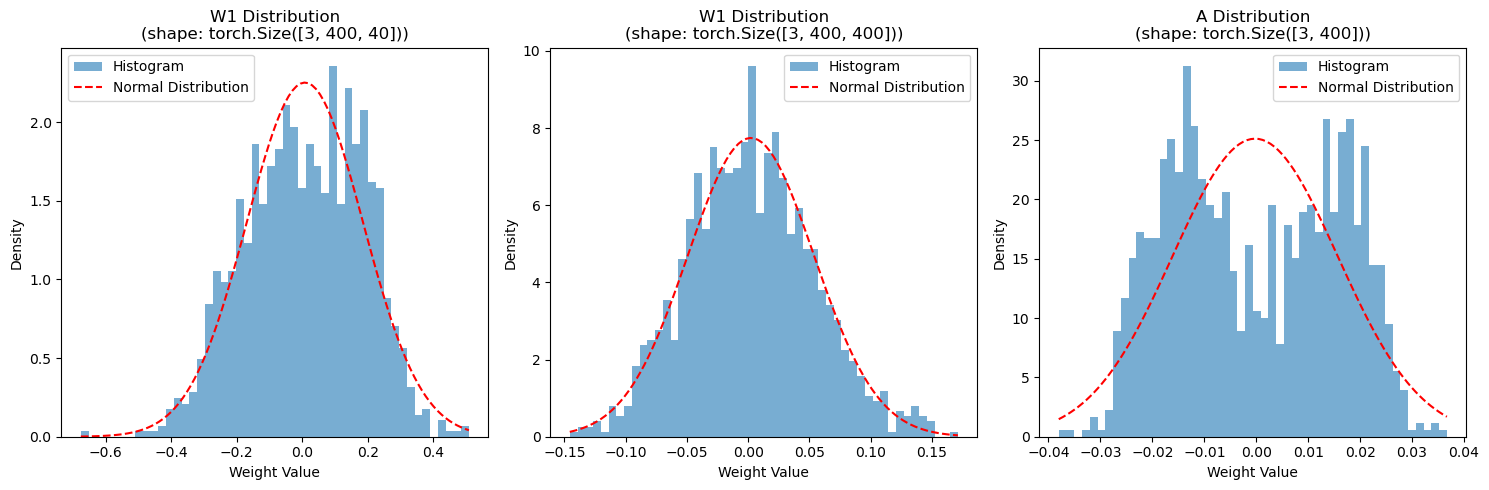


Summary Statistics:

W0 Targ:
Mean: 0.008142
Std: 0.177192
Skewness: -0.160294
Kurtosis: -0.475009

W1 Perp:
Mean: 0.002213
Std: 0.051522
Skewness: 0.170434
Kurtosis: -0.046056

A:
Mean: -0.000222
Std: 0.015879
Skewness: 0.040629
Kurtosis: -1.238932

Shapiro-Wilk Test (p-value):
W0: 0.000001
W1: 0.047980
A:  0.000000
---------------(((( SSC Exp ))))------------


NameError: name 'experimentNNGP' is not defined

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def gaussianity_test(experiment):
    model = experiment.model
    # Set up the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Helper function to plot histogram and normal curve
    def plot_distribution(ax, data, title):
        # Plot histogram
        counts, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, label='Histogram')
        
        # Fit and plot normal distribution
        mu, sigma = np.mean(data), np.std(data)
        x = np.linspace(min(bins), max(bins), 100)
        norm_curve = stats.norm.pdf(x, mu, sigma)
        ax.plot(x, norm_curve, 'r--', label='Normal Distribution')
        
        ax.set_title(title)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Density')
        ax.legend()


    # Plot W0 distribution
    w0_flat = model.W0[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax1, w0_flat, f'W1 Distribution\n(shape: {model.W0.shape})')

    # Plot W1 distribution
    w1_flat = model.W1[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax2, w1_flat, f'W1 Distribution\n(shape: {model.W1.shape})')

    # Plot A distribution
    a_flat = model.A.detach().cpu().numpy().flatten()
    plot_distribution(ax3, a_flat, f'A Distribution\n(shape: {model.A.shape})')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nW0 Targ:")
    print(f"Mean: {np.mean(w0_flat):.6f}")
    print(f"Std: {np.std(w0_flat):.6f}")
    print(f"Skewness: {stats.skew(w0_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w0_flat):.6f}")

    print("\nW1 Perp:")
    print(f"Mean: {np.mean(w1_flat):.6f}")
    print(f"Std: {np.std(w1_flat):.6f}")
    print(f"Skewness: {stats.skew(w1_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w1_flat):.6f}")

    print("\nA:")
    print(f"Mean: {np.mean(a_flat):.6f}")
    print(f"Std: {np.std(a_flat):.6f}")
    print(f"Skewness: {stats.skew(a_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(a_flat):.6f}")

    # Add Shapiro-Wilk test for normality
    print("\nShapiro-Wilk Test (p-value):")
    print(f"W0: {stats.shapiro(w0_flat)[1]:.6f}")
    print(f"W1: {stats.shapiro(w1_flat)[1]:.6f}")
    print(f"A:  {stats.shapiro(a_flat)[1]:.6f}")

print("---------------(((( MF Exp ))))------------")
gaussianity_test(experimentMF)
print("---------------(((( SSC Exp ))))------------")
gaussianity_test(experimentNNGP)

In [ ]:
def plot_distribution(ax, data, title):
    # Plot histogram
    counts, bins, _ = ax.hist(data, bins=40, density=True, alpha=0.6, label='Histogram')
    
    # Fit and plot normal distribution
    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(min(bins), max(bins), 40)
    norm_curve = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, norm_curve, 'r--', label='Normal Distribution')
    
    ax.set_title(title)
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.legend()


In [ ]:
def covariance_over_k_averaged(W: torch.Tensor) -> torch.Tensor:
    """
    Parameters
    ----------
    W : torch.Tensor
        Tensor of shape (I, J, K).  `i` = 0..I-1, `j` = 0..J-1, `k` = 0..K-1.

    Returns
    -------
    torch.Tensor
        A (K, K) covariance matrix obtained by:
          1. For every (i,j) compute cov(W[i,j,:])
          2. Average those (I*J) covariance matrices.
    """
    I, J, K = W.shape

    # 1. Reshape so that each (i,j) is a separate "sample"
    #    -> shape (I*J, K)
    X = W.reshape(I * J, K)                # (N, K)  with N = I*J

    # 2. Center the data (subtract column means)
    X_centered = X - X.mean(dim=1, keepdim=True)   # (N, K)

    # 3. Compute the (biased) covariance for each sample separately
    #    cov_per_sample = (1/K) * X_centered.T @ X_centered   would be the *global* cov
    #    Instead we need the per-sample cov and then average them:
    #    cov_ij = (1/(K-1)) * X_centered[n:n+1].T @ X_centered[n:n+1]
    #    (the 1/(K-1) is the unbiased estimator for a single vector)

    # Vectorized per-sample outer product:
    #    (N, K, 1) @ (N, 1, K)  ->  (N, K, K)
    outer = X_centered.unsqueeze(-1) * X_centered.unsqueeze(-2)   # (N, K, K)

    # Unbiased covariance for a single vector of length K:
    cov_per_ij = outer / (K - 1)                                 # (N, K, K)

    # 4. Average over all (i,j) pairs
    cov_avg = cov_per_ij.mean(dim=0)                            # (K, K)

    return cov_avg

# cov_avg = covariance_over_k_averaged(model.W1).detach().cpu().numpy()
